In [1]:
%matplotlib inline


Single Field of View for sequential single-molecule FISH processed in 3d
========================================================================

This notebook walks through a work flow that analyzes one field of view of a mouse gene panel from
the Allen Institute for Brain Science, using the starfish package.

This example processes an experiment with a single round from a single field of view of sequential
smFISH data taken from mouse primary visual cortex. These data are unpublished, and were kindly
contributed by the Allen Institute for Brain Science as a part of the SpaceTx consortium
project.

The data consist of 45 images from 1 round, 1 channels, and 33 z-planes. Each image is
(2048, 2048) (y, x). There are no test data.



In [2]:
import xarray as xr

import pprint

from typing import Optional, Tuple
from IPython import get_ipython

import starfish
import starfish.data
from starfish import FieldOfView, IntensityTable, Experiment
from starfish.types import Features, Axes
from starfish.util.plot import imshow_plane

# equivalent to %gui qt
ipython = get_ipython()
ipython.magic("gui qt5")

Define image filters
--------------------
The 3d smFISH workflow run by the Allen runs a bandpass filter to remove high and low frequency
signal and blurs over z with a 1-pixel gaussian to smooth the signal over the z-axis.

low-intensity signal is (stringently) clipped from the images before and after these filters.


In [3]:
# bandpass filter to remove cellular background and camera noise
bandpass = starfish.image.Filter.Bandpass(lshort=.5, llong=7, threshold=0.0)

# gaussian blur to smooth z-axis
glp = starfish.image.Filter.GaussianLowPass(
    sigma=(1, 0, 0),
    is_volume=True
)

# pre-filter clip to remove low-intensity background signal
clip1 = starfish.image.Filter.Clip(p_min=50, p_max=100)

# post-filter clip to eliminate all but the highest-intensity peaks
clip2 = starfish.image.Filter.Clip(p_min=99, p_max=100, is_volume=True)

Define a spot detection method
------------------------------
Spots are detected using a spot finder based on trackpy's locate method, which identifies
local intensity maxima, and spots are matched to the gene they represent by looking them up in a
codebook that records which (round, channel) matches which gene target.


In [4]:
tlmpf = starfish.spots.DetectSpots.TrackpyLocalMaxPeakFinder(
    spot_diameter=5,  # must be odd integer
    min_mass=0.02,
    max_size=2,  # this is max radius
    separation=7,
    noise_size=0.65,  # this is not used because preprocess is False
    preprocess=False,
    percentile=10,  # this is irrelevant when min_mass, spot_diameter, and max_size are set properly
    verbose=True,
    is_volume=True,
)

Construct the pipeline
----------------------


In [5]:
# override print to print to stderr for cromwell
from functools import partial
import sys
print = partial(print, file=sys.stderr)

def processing_pipeline(
    experiment: starfish.Experiment,
    fov_name: str,
    n_processes: Optional[int]=None
) -> Tuple[starfish.ImageStack, starfish.IntensityTable]:
    """Process a single field of view of an experiment

    Parameters
    ----------
    experiment : starfish.Experiment
        starfish experiment containing fields of view to analyze
    fov_name : str
        name of the field of view to process
    n_processes : int

    Returns
    -------
    starfish.IntensityTable :
        decoded IntensityTable containing spots matched to the genes they are hybridized against
    """

    print("Loading images...")
    primary_image = experiment[fov_name].get_image(FieldOfView.PRIMARY_IMAGES)
    all_intensities = list()
    codebook = experiment.codebook
    
    images = enumerate(experiment[fov_name].iterate_image_type(FieldOfView.PRIMARY_IMAGES))

    for image_number, primary_image in images:

        print(f"Filtering image {image_number}...")
        filter_kwargs = dict(
            in_place=True,
            verbose=True,
            n_processes=n_processes
        )
        print("Applying Clip...")
        clip1.run(primary_image, **filter_kwargs)
        print("Applying Bandpass...")
        bandpass.run(primary_image, **filter_kwargs)
        print("Applying Gaussian Low Pass...")
        glp.run(primary_image, **filter_kwargs)
        print("Applying Clip...")
        clip2.run(primary_image, **filter_kwargs)

        print("Calling spots...")
        spot_attributes = tlmpf.run(primary_image)
        all_intensities.append(spot_attributes)

    spot_attributes = IntensityTable.concatenate_intensity_tables(all_intensities)

    print("Decoding spots...")
    decoded = codebook.decode_per_round_max(spot_attributes)
    decoded = decoded[decoded["total_intensity"] > .025]
    
    print("Processing complete.")

    return primary_image, decoded

Load data, run pipeline, display results
----------------------------------------


In [6]:
import os
#experiment = starfish.data.allen_smFISH(use_test_data=True)
experiment_json1 = os.path.abspath("/Users/at22/IMAGES/omer/Hiplex_run1_cycle1_MsPos__2019-03-05T10_52_04-Measurement_2/spacetx/experiment.json")
experiment1 = Experiment.from_json(experiment_json1)
#primary_image = experiment.fov()[FieldOfView.PRIMARY_IMAGES]
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment1._src_doc)


#experiment = starfish.data.allen_smFISH(use_test_data=True)
experiment_json2 = os.path.abspath("/Users/at22/IMAGES/omer/Hiplex_run1_cycle2_MsPos__2019-03-05T15_06_25-Measurement_2/spacetx/experiment.json")
experiment2 = Experiment.from_json(experiment_json2)
#primary_image = experiment.fov()[FieldOfView.PRIMARY_IMAGES]
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment2._src_doc)

{ 'codebook': 'codebook.json',
  'extras': {},
  'images': { 'dapi': 'dapi_image-fov.json',
              'primary': 'primary_image-fov.json'},
  'version': '5.0.0'}
{ 'codebook': 'codebook.json',
  'extras': {},
  'images': {'dapi': 'dapi-fov.json', 'primary': 'primary_image-fov.json'},
  'version': '5.0.0'}


In [7]:
fov1 = experiment1['fov_008']#.fov()
primary_image1 = fov1.get_image(FieldOfView.PRIMARY_IMAGES)
dapi1 = fov1.get_image("dapi")
images1 = [primary_image1, dapi1]

fov2 = experiment2['fov_008']#.fov()
primary_image2 = fov2.get_image(FieldOfView.PRIMARY_IMAGES)
dapi2 = fov2.get_image("dapi")
images2 = [primary_image2, dapi2]

100%|██████████| 25/25 [00:00<00:00, 28.24it/s]


100%|██████████| 1/1 [00:00<00:00, 298.95it/s]


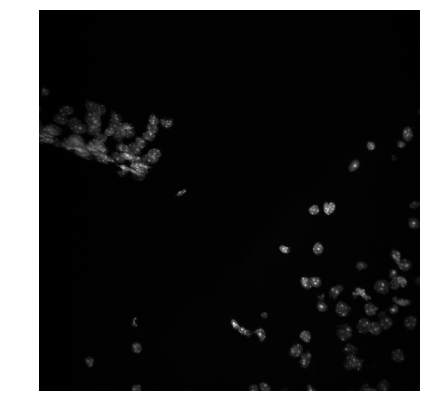

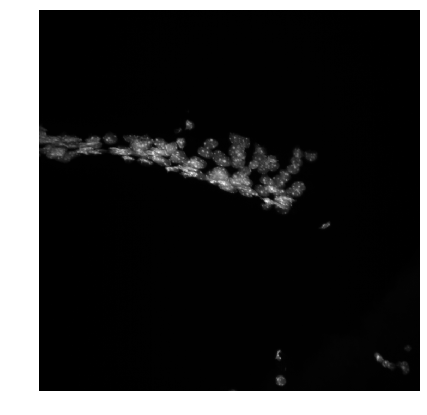

In [8]:
import showit

dapi_mp1 = dapi1.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
dapi_mp_numpy1 = dapi_mp1._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
showit.image(dapi_mp_numpy1)

dapi_mp2 = dapi2.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
dapi_mp_numpy2 = dapi_mp2._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
showit.image(dapi_mp_numpy2)

In [9]:
image, intensities = processing_pipeline(experiment1, fov_name='fov_008')

# uncomment the below line to visualize the output with the spot calls.
# viewer = starfish.display(image, intensities)

Loading images...
100%|██████████| 75/75 [00:02<00:00, 30.62it/s]
Filtering image 0...
Applying Clip...
75it [00:00, 144.80it/s]
Applying Bandpass...
75it [00:00, 82.81it/s]
Applying Gaussian Low Pass...
3it [00:00, 74.53it/s]
Applying Clip...
3it [00:00, 55.76it/s]
Calling spots...
Decoding spots...
Processing complete.


In [10]:
viewer = starfish.display(image, intensities)